# Ornstein-Uhlenbeck process and applications


## Contents
   - [Ornstein-Uhlenbeck process](#sec1)
      - [Numerical simulation](#sec1.1)
      - [Parameters estimation from a single path](#sec1.2)
      - [Expected time to reach the long term mean](#sec1.3)
   - [Bond Pricing by Vasicek model](#sec2)
   - [Tracking the OU process](#sec3)
      - [Iterative approach for parameters estimation](#sec3.1)
   - [Trading strategy](#sec4)
   - [First time to exit the strip](#sec5)

In [2]:
import numpy as np
import scipy as scp
import scipy.stats as ss
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve
from mpl_toolkits import mplot3d
from matplotlib import cm
import scipy.special as scsp
from scipy.integrate import quad
from FMNM.Processes import OU_process
from scipy.interpolate import RegularGridInterpolator

<a id='sec1'></a>
# OU process

The [Ornstein-Uhlenbeck process](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process) 
is described by the following SDE: 

$$ dX_t = \kappa (\theta - X_t) dt + \sigma dW_t .$$

The parameters are:
- $\kappa > 0$:  mean reversion coefficient
- $\theta \in \mathbb{R}$:  long term mean  
- $\sigma > 0$:   volatility coefficient

This process is Gaussian, Markovian and (unconditionally) stationary.

##### The previous SDE can be solved!  Let's do it!

First of all we can define the new process $Y_t = X_t - \theta$ such that the differential is equal $dY_t = dX_t$.      
The SDE becomes:

$$ dY_t = - \kappa \, Y_t \, dt + \sigma \, dW_t .$$

Let us introduce the function: $f(t,y) = y e^{\kappa t}$.      
This function has derivatives:

$$ \frac{\partial f}{\partial t} = y\, \kappa\, e^{\kappa t}  \quad \frac{\partial f}{\partial y} = e^{\kappa t} 
\quad \frac{\partial^2 f}{\partial y^2} = 0 .$$

We can use the Itô formula:

$$ \begin{aligned}
d( Y_t \, e^{\kappa t} ) &= \kappa \, Y_t\, e^{\kappa t}\, dt + e^{\kappa t}\, dY_t \\ 
                         &= \kappa \, Y_t\, e^{\kappa t}\, dt + e^{\kappa t}\, \biggl( - \kappa \, Y_t \, dt + \sigma \, dW_t \biggr) \\
                         &= e^{\kappa t} \sigma dW_t .
\end{aligned} $$

For convenience, let us replace the time variable $t$ with $s$, and then let us integrate both sides on $[0,t]$:

$$ Y_t\, e^{\kappa t} - Y_0 = \int_0^t e^{\kappa s} \sigma dW_t .$$

At this point we can return to the original variable $X_t$ and obtain the final solution:

$$ X_t = \theta + (X_0 - \theta)e^{-\kappa t} + \int_0^t \sigma\, e^{\kappa (s-t)} dW_s .$$

### Moments:

The **mean** of $X_t$ is:

$$ \begin{aligned}
\mathbb{E}[X_t] &= \mathbb{E}\biggl[ \theta + (X_0 - \theta)e^{-\kappa t} + \int_0^t \sigma\, e^{\kappa (s-t)} dW_s \biggr] \\
                &= \theta + (X_0 - \theta)e^{-\kappa t}    
\end{aligned}$$

where the Itô integral is a martingale, $ \mathbb{E}\bigl[ \int_0^t \sigma\, e^{\kappa (s-t)} dW_s \bigr] = 0$.

The **covariance** is:

$$ \begin{aligned}
\text{Cov}[X_s, X_t] &= \text{Cov}\biggl[ \int_0^s \sigma\, e^{\kappa (u-s)} dW_u \, , \, 
\int_0^t \sigma\, e^{\kappa (v-t)} dW_v \biggr] =  \mathbb{E}\biggl[ \int_0^s \sigma\, e^{\kappa (u-s)} dW_u 
\int_0^t \sigma\, e^{\kappa (v-t)} dW_v \biggr] \\
                &= \sigma^2 e^{-\kappa (s+t)}\, \mathbb{E}\biggl[ \int_0^s e^{\kappa u} dW_u 
\int_0^t e^{\kappa v} dW_v \biggr] \\
                &= \sigma^2 e^{-\kappa (s+t)}\, \mathbb{E}\biggl[ \biggl( \int_0^{\text{min}(t,s)} e^{\kappa u} dW_u  + \int_{\text{min}(t,s)}^{\text{max}(t,s)} e^{\kappa u} dW_u \biggr) \cdot 
\int_0^{\text{min}(t,s)} e^{\kappa v} dW_v \biggr] \\
                &= \sigma^2 e^{-\kappa (s+t)}\, \mathbb{E}\biggl[ \biggl( \int_0^{\text{min}(t,s)} e^{\kappa u}   dW_u \biggr)^2 \biggr] \\
                &= \sigma^2 e^{-\kappa (s+t)}\, \int_0^{\text{min}(t,s)} e^{2 \kappa u} du \; = \; \frac{\sigma^2}{2\kappa} e^{-\kappa (s+t)}\, \biggl( e^{2\kappa\, \text{min}(t,s)} - 1 \biggr)  \\
                &= \frac{\sigma^2}{2\kappa} \biggl( e^{-\kappa |t-s|} - e^{-\kappa (s+t)}\, \biggr),  
\end{aligned}$$

where in the first line I remove the non-random variables, in the third line I use the independence property (expectiation of the product is equal to the product of expectation) and in the fourth line I use the Itô isometry.

The **variance** is: 

$$ \text{Var}[X_t] = \text{Cov}[X_t, X_t] = \frac{\sigma^2}{2\kappa} \biggl( 1- e^{-2 \kappa t} \biggr).$$

As $t\to \infty$ we obtain the **asymptotic mean**: $\theta$ and the **asymptotic variance**: $\frac{\sigma^2}{2\kappa}$.

<a id='sec1.1'></a>
## Numerical simulation

We can discretize the SDE using the Euler-Maruyama numerical method (see Notebook **1.2**).
This discretization is commented in the code below.

Another possibility is to generate the dynamics from the solution of the SDE.     
Let us consider the solution of the OU SDE obtained above. We can compute $X_{n+1}$ and consider the initial value at time $n$.

$$ X_{n+1} = \theta + (X_n - \theta)e^{-\kappa \Delta t} + \sqrt{\frac{\sigma^2}{2\kappa} \bigl( 1- e^{-2 \kappa \Delta t} \bigr)} \; \epsilon_n $$ 

with $\epsilon_n \sim \mathcal{N}(0,1)$.

In [3]:
np.random.seed(seed=42)

N = 20000  # time steps
paths = 5000  # number of paths
T = 5
T_vec, dt = np.linspace(0, T, N, retstep=True)

kappa = 3
theta = 0.5
sigma = 0.5
std_asy = np.sqrt(sigma**2 / (2 * kappa))  # asymptotic standard deviation

X0 = 2
X = np.zeros((paths, N))
X[:, 0] = X0
W = ss.norm.rvs(loc=0, scale=1, size=(paths, N - 1))

# Uncomment for Euler Maruyama
# for t in range(0,N-1):
#    X[:,t+1] = X[:,t] + kappa*(theta - X[:,t])*dt + sigma * np.sqrt(dt) * W[:,t]

std_dt = np.sqrt(sigma**2 / (2 * kappa) * (1 - np.exp(-2 * kappa * dt)))
for t in range(0, N - 1):
    X[:, t + 1] = theta + np.exp(-kappa * dt) * (X[:, t] - theta) + std_dt * W[:, t]

X_T = X[:, -1]  # values of X at time T
X_1 = X[1, :]  # a single path

#### Mean and standard deviation

Since we have the possibility to generate several paths, let us consider the values at time T. We compute theoretical mean and standard deviation and compare them with the values obtained from the data:

In [4]:
mean_T = theta + np.exp(-kappa * T) * (X0 - theta)
std_T = np.sqrt(sigma**2 / (2 * kappa) * (1 - np.exp(-2 * kappa * T)))

param = ss.norm.fit(X_T)  # FIT from data
print(f"Theoretical mean={mean_T.round(6)} and theoretical STD={std_T.round(6)}")
print("Parameters from the fit: mean={0:.6f}, STD={1:.6f}".format(*param))  # these are MLE parameters

Theoretical mean=0.5 and theoretical STD=0.204124
Parameters from the fit: mean=0.499119, STD=0.200778


#### Plot

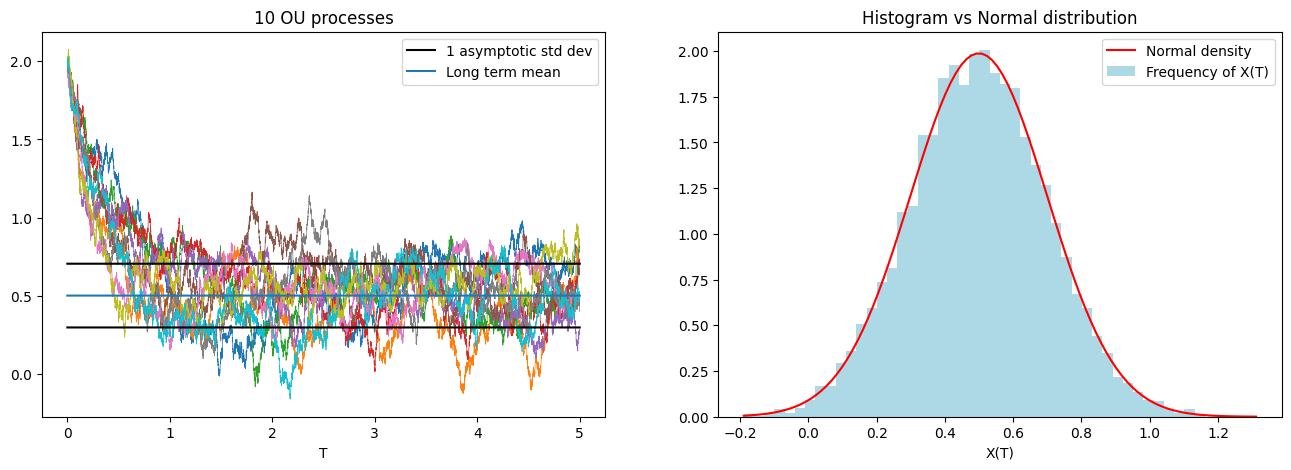

In [5]:
N_processes = 10  # number of processes
x = np.linspace(X_T.min(), X_T.max(), 100)
pdf_fitted = ss.norm.pdf(x, *param)

fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(T_vec, X[:N_processes, :].T, linewidth=0.5)
ax1.plot(T_vec, (theta + std_asy) * np.ones_like(T_vec), label="1 asymptotic std dev", color="black")
ax1.plot(T_vec, (theta - std_asy) * np.ones_like(T_vec), color="black")
ax1.plot(T_vec, theta * np.ones_like(T_vec), label="Long term mean")
ax1.legend(loc="upper right")
ax1.set_title(f"{N_processes} OU processes")
ax1.set_xlabel("T")
ax2.plot(x, pdf_fitted, color="r", label="Normal density")
ax2.hist(X_T, density=True, bins=50, facecolor="LightBlue", label="Frequency of X(T)")
ax2.legend()
ax2.set_title("Histogram vs Normal distribution")
ax2.set_xlabel("X(T)")
plt.show()

#### Covariance

Let us also compare the theoretical covariance with the covariance obtained from the data.

In [6]:
n1 = 5950
n2 = 6000
t1 = n1 * dt
t2 = n2 * dt

cov_th = sigma**2 / (2 * kappa) * (np.exp(-kappa * np.abs(t1 - t2)) - np.exp(-kappa * (t1 + t2)))
print(f"Theoretical COV[X(t1), X(t2)] = {cov_th.round(4)} with t1 = {t1.round(4)} and t2 = {t2.round(4)}")
print(f"Computed covariance from data COV[X(t1), X(t2)] = {np.cov( X[:,n1], X[:,n2] )[0,1].round(4)}")

Theoretical COV[X(t1), X(t2)] = 0.0401 with t1 = 1.4876 and t2 = 1.5001
Computed covariance from data COV[X(t1), X(t2)] = 0.0401


<a id='sec1.2'></a>
## Estimation of parameters from a single path

### Least squares estimation

We can compute $X_{t+\Delta t}$ and consider the initial value at time $t$.

$$ \begin{aligned}
X_{t+\Delta t} &= \theta + (X_t - \theta)e^{-\kappa \Delta t} + \int_t^{t+\Delta t} \sigma\, e^{\kappa (s-t)} dW_s \\
               &= \theta \bigl( 1-e^{-\kappa \Delta t} \bigr) + e^{-\kappa \Delta t} X_t + \int_t^{t+\Delta t} \sigma\, e^{\kappa (s-t)} dW_s \\
               &= \alpha + \beta X_t + \epsilon_t
\end{aligned} $$

where $\alpha = \theta \bigl( 1-e^{-\kappa \Delta t} \bigr)$, $\beta = e^{-\kappa \Delta t}$ and with $\epsilon_t \sim \mathcal{N}\biggl( 0, \frac{\sigma^2}{2\kappa} \bigl( 1- e^{-2 \kappa \Delta t} \bigr)\biggr)$.

So, let us use the usual OLS method to estimate $\alpha$, $\beta$ and $\sigma$.
Then, we can obtain the parameters from the formulas:

$$ \kappa = - \frac{\log \beta}{\Delta t}, \quad \theta = \frac{\alpha}{1-\beta}, \quad 
\sigma = \text{Std}[\epsilon_t] \sqrt{ \frac{2\kappa}{1-\beta^2} }$$

In [7]:
XX = X_1[:-1]
YY = X_1[1:]
beta, alpha, _, _, _ = ss.linregress(XX, YY)  # OLS
kappa_ols = -np.log(beta) / dt
theta_ols = alpha / (1 - beta)
res = YY - beta * XX - alpha  # residuals
std_resid = np.std(res, ddof=2)
sig_ols = std_resid * np.sqrt(2 * kappa_ols / (1 - beta**2))

print("OLS theta = ", theta_ols)
print("OLS kappa = ", kappa_ols)
print("OLS sigma = ", sig_ols)

OLS theta =  0.40273215093892223
OLS kappa =  3.4448221867780426
OLS sigma =  0.49904604497283017


The estimate of the parameters doesn't look very accurate. 

### Maximum Likelihood Estimation

We know that 
$$ X_{i+1} \sim \mathcal{N}\biggl( \theta \bigl( 1-e^{-\kappa \Delta t} \bigr) + e^{-\kappa \Delta t} X_i \, , \, \frac{\sigma^2}{2\kappa} \bigl( 1- e^{-2 \kappa \Delta t} \bigr)\biggr)$$

Let us define $\hat \theta^2 := \frac{\sigma^2}{2\kappa} \bigl( 1- e^{-2 \kappa \Delta t} \bigr)$.

At this point it is possible to write the log-likelihood function and impose the condition that first order derivatives are equal to zero. All these steps are done in [1]. 
Here I just recall the final formulas:

$$ S_x = \sum_{i=1}^n X_{i-1} \quad S_y = \sum_{i=1}^n X_{i} \quad S_{xx} = \sum_{i=1}^n X_{i-1}^2 
\quad S_{xy} = \sum_{i=1}^n X_{i-1}X_{i} \quad S_{yy} = \sum_{i=1}^n X_{i}^2$$

The parameters are:

$$ \theta = \frac{S_y S_{xx} - S_x S_{xy}}{n(S_{xx}-S_{xy}) - (S_{x}^2 - S_{x} S_{y})} $$

$$ \kappa = - \frac{1}{\Delta t} \log \frac{S_{xy} - \theta S_{x} - \theta S_{y} +n\theta^2}{S_{xx} - 2\theta S_{x} +n \theta^2} $$

$$ 
\hat \theta^2 = \frac{1}{n} \biggl[ S_{yy} -2e^{-\kappa \Delta t} S_{xy} 
+ e^{-2 \kappa \Delta t} S{xx} -2\theta(1-e^{- \kappa \Delta t})(S_y - e^{- \kappa \Delta t}S_x) 
+n \theta^2(1-e^{- \kappa \Delta t})^2 \biggr] $$
$$ \theta^2 = \hat \theta^2 \frac{2\kappa}{1-e^{-2 \kappa \Delta t}} $$

In [8]:
Sx = np.sum(XX)
Sy = np.sum(YY)
Sxx = XX @ XX
Sxy = XX @ YY
Syy = YY @ YY

theta_mle = (Sy * Sxx - Sx * Sxy) / (N * (Sxx - Sxy) - (Sx**2 - Sx * Sy))
kappa_mle = -(1 / dt) * np.log(
    (Sxy - theta_mle * Sx - theta_mle * Sy + N * theta_mle**2) / (Sxx - 2 * theta_mle * Sx + N * theta_mle**2)
)
sigma2_hat = (
    Syy
    - 2 * np.exp(-kappa_mle * dt) * Sxy
    + np.exp(-2 * kappa_mle * dt) * Sxx
    - 2 * theta_mle * (1 - np.exp(-kappa_mle * dt)) * (Sy - np.exp(-kappa_mle * dt) * Sx)
    + N * theta_mle**2 * (1 - np.exp(-kappa_mle * dt)) ** 2
) / N
sigma_mle = np.sqrt(sigma2_hat * 2 * kappa_mle / (1 - np.exp(-2 * kappa_mle * dt)))

In [9]:
print("theta MLE = ", theta_mle)
print("kappa MLE = ", kappa_mle)
print("sigma MLE = ", sigma_mle)

theta MLE =  0.40270576101902894
kappa MLE =  3.4444961212407144
sigma MLE =  0.49900861888536313


With the MLE we obtain parameters quite similar to those obtained by OLS.

<a id='sec1.3'></a>
## Expected time to reach the long term mean

Computation of the first hitting time density of an Ornstein-Uhlenbeck process is a long standing problem, which still remains open.       
As explained in the introduction of the paper [5], the first hitting time of an OU process has many applications in applied mathematics, especially in mathematical finance and for the design of trading strategies.

Let us define the first hitting time for the OU process:

$$ T_{A,C} = \inf\biggl\{ t\geq 0 \;: \; X_t = A \bigg| X_0 = C   \biggr\} $$

Here I follow the presentation of the article [4], where the author considers the standardized problem with $\theta=0$, $\kappa=1$ and $\sigma^2=2$. 

$$ dX_t = - X_t dt + \sqrt{2} dW_t .$$

This is a common choice, and many articles cited in [4] follow this approach (see [6]). In [5] the authors use $\sigma=1$, (which in my opinion looks better). 

The standardized form can be obtained with the following change of variables:

$$ \bar t = \kappa t, \quad \bar X_t = \frac{\sqrt{2\kappa}}{\sigma}(X_t-\theta), \quad \bar C = \frac{\sqrt{2\kappa}}{\sigma}(C-\theta), \quad \bar A = \frac{\sqrt{2\kappa}}{\sigma}(A-\theta) $$

(the bar is then removed for brevity).    

Let $f_{A,C}(t)$ denote the density function of $T_{A,C}$. For $A=0$, the density has a nice expression:

$$ f_{0,C}(t) = \sqrt{\frac{2}{\pi}} \frac{|C| e^{-t}}{(1-e^{-2t})^{3/2}} \exp\biggl[- \frac{C^2e^{-2t}}{2(1-e^{-2t})}  \biggr] $$

Thanks to the change of variable, the expected time it takes for a process starting at $X_0$ to reach 
$\theta$, is equal to the (scaled) expected time it takes for a process to reach $0$ starting at $\bar C$ (set $A=\theta$ implies $\bar A = 0$).

#### Let us estimate the expected time numerically

In [10]:
T_to_theta = np.argmax(X <= theta if (X0 > theta) else X >= theta, axis=1) * dt  # first passage time

In [11]:
print(f"The expected time from X0 to theta is: {T_to_theta.mean()} with std error: {ss.sem(T_to_theta)}")
print("The standard deviation of the first time the process touches theta is: ", T_to_theta.std())

The expected time from X0 to theta is: 0.8894928746437323 with std error: 0.005239225702876141
The standard deviation of the first time the process touches theta is:  0.37043215349429953


#### Now we can define the density and the new starting point C.

When comparing with the histogram, we need to take into account of the time scale: $\kappa t$.     
Therefore the density becomes:  $\kappa f_{0,C}(\kappa t)$.

In [12]:
def density_T_to_theta(t, C):
    return (
        np.sqrt(2 / np.pi)
        * np.abs(C)
        * np.exp(-t)
        / (1 - np.exp(-2 * t)) ** (3 / 2)
        * np.exp(-((C**2) * np.exp(-2 * t)) / (2 * (1 - np.exp(-2 * t))))
    )

In [13]:
C = (X0 - theta) * np.sqrt(2 * kappa) / sigma  # new starting point

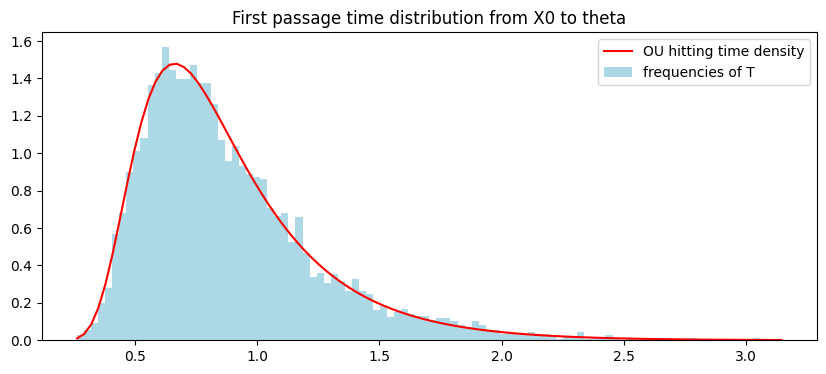

In [14]:
fig = plt.figure(figsize=(10, 4))
x = np.linspace(T_to_theta.min(), T_to_theta.max(), 100)
plt.plot(x, kappa * density_T_to_theta(kappa * x, C), color="red", label="OU hitting time density")
plt.hist(T_to_theta, density=True, bins=100, facecolor="LightBlue", label="frequencies of T")
plt.title("First passage time distribution from X0 to theta")
plt.legend()
plt.show()

We can now compute the theoretical mean and standard deviation:

In [15]:
theoretical_T = quad(lambda t: t * kappa * density_T_to_theta(kappa * t, C), 0, 1000)[0]
theoretical_std = np.sqrt(
    quad(lambda t: (t - theoretical_T) ** 2 * kappa * density_T_to_theta(kappa * t, C), 0, 1000)[0]
)
print("Theoretical expected hitting time: ", theoretical_T)
print("Theoretical standard deviation of the hitting time: ", theoretical_std)

Theoretical expected hitting time:  0.8795633378038916
Theoretical standard deviation of the hitting time:  0.3675713561470198


<a id='sec2'></a>
# Bond Pricing by Vasicek model

The [Vasicek model](https://en.wikipedia.org/wiki/Vasicek_model) describes the evolution of the interest rate process $\{r_t\}_{t \in [0,T]}$ assuming it follows an OU process under the risk neutral dynamics (I indicate with $\mathbb{Q}$ the risk neutral measure).

We write:

$$ dr_t = \kappa (\theta - r_t) dt + \sigma dW_t^{\mathbb{Q}} .$$

The price of a **zero-coupon bond** has the following formula:

$$ P(t,T) = \mathbb{E}^{\mathbb{Q}}\biggl[ e^{\int_t^T r_s \, ds} \; \bigg|\; \mathcal{F}_t \biggr]. $$

Thanks to the [Feynman-Kac](https://en.wikipedia.org/wiki/Feynman%E2%80%93Kac_formula) formula, we know that the previous expression is a solution of the following PDE:

$$ \frac{\partial  P(t,r)}{\partial t}  
          + \kappa (\theta - r) \frac{\partial P(t,r)}{\partial r}
          + \frac{1}{2} \sigma^2 \frac{\partial^2  P(t,r)}{\partial r^2} - r  P(t,r)  = 0. $$
          
with terminal conditions:

$$ P(T,r) = 1. $$

Following [2] (page 59), we can find the closed formula for the bond price under the Vasicek model:

$$ P(t,T) = A(t,T) e^{-B(t,T) r_t} $$

with 

$$ A(t,T) = exp\biggl[ \biggl(\theta - \frac{\sigma^2}{2\kappa^2}\biggr)(B(t,T)-T+t) - \frac{\sigma^2}{4\kappa} B(t,T)^2 \biggr] \quad \text{and} \quad 
B(t,T) = \frac{1}{\kappa} \biggl( 1 - e^{-\kappa (T-t)} \biggr) .$$

#### Closed formula:

In [16]:
B = 1 / kappa * (1 - np.exp(-kappa * T))
A = np.exp((theta - sigma**2 / (2 * kappa**2)) * (B - T) - sigma**2 / (4 * kappa) * B**2)
P = A * np.exp(-B * X0)
print("Vasicek bond price: ", P)

Vasicek bond price:  0.05299806665958418


#### Monte Carlo

In [17]:
disc_factor = np.exp(-X.mean(axis=1) * T)
P_MC = np.mean(disc_factor)
st_err = ss.sem(disc_factor)
print(f"Vasicek bond price by MC: {P_MC} with std error: {st_err}")

Vasicek bond price by MC: 0.05334774031341052 with std error: 0.0002745991722043543


#### PDE

As done in the notebook **2.2**, we can discretize the PDE
using the [Upwind scheme](https://en.wikipedia.org/wiki/Upwind_scheme):    

$$
 \frac{P^{n+1}_{i} -P^{n}_{i}}{\Delta t}  
          + \max \biggl( \kappa(\theta-r_i),\, 0 \biggr) \frac{P^{n}_{i+1} -P^{n}_{i}}{ \Delta r} 
          + \min \biggl( \kappa(\theta-r_i),\, 0 \biggr) \frac{P^{n}_{i} -P^{n}_{i-1}}{ \Delta r} 
          + \frac{1}{2} \sigma^2  \frac{P^{n}_{i+1} + P^{n}_{i-1} - 2 P^{n}_{i}}{\Delta r^2} 
          - r_i  P^{n}_i  = 0. 
$$

For convenience, let's call $\text{max}_i = \max \bigl( \kappa(\theta-r_i),\, 0 \bigr)$ and $\text{min}_i = \min \bigl( \kappa(\theta-r_i),\, 0 \bigr)$.     
We can rewrite the equation above as:

$$ \begin{aligned}
P^{n+1}_{i} =& \; P^{n}_{i-1} \biggl( \text{min}_i \frac{\Delta t}{\Delta r} -\frac{1}{2} \sigma^2 
\frac{\Delta t}{\Delta r^2} \biggr)  \\
             & + P^{n}_{i} \biggl( 1 + r_i \Delta t + \frac{\Delta t}{\Delta r}( \text{max}_i - \text{min}_i ) + \sigma^2 \frac{\Delta t}{\Delta r^2} \biggr) \\
             & + P^{n}_{i+1} \biggl( -\text{max}_i \frac{\Delta t}{\Delta r} -\frac{1}{2} \sigma^2 
\frac{\Delta t}{\Delta r^2} \biggr)
\end{aligned}$$

and, given $P^{n+1}$, we solve for $P^{n}$.     
I also introduce the artificial lateral boundary conditions:

$$ P(t, r_{\text{min}}) = e^{-r_{\text{min}} (T-t)} \quad \text{and} \quad P(t, r_{\text{max}}) = e^{-r_{\text{max}} (T-t)}. $$

although the resulting values are too extreme. (a high-resolution grid mitigates this problem).    

See also notebook **2.1** for the description of the application of the finite difference implicit scheme. 

In [18]:
Nspace = 6000  # M space steps
Ntime = 6000  # N time steps
r_max = 3  # A2
r_min = -0.8  # A1
r, dr = np.linspace(r_min, r_max, Nspace, retstep=True)  # space discretization
T_array, Dt = np.linspace(0, T, Ntime, retstep=True)  # time discretization
Payoff = 1  # Bond payoff

V = np.zeros((Nspace, Ntime))  # grid initialization
offset = np.zeros(Nspace - 2)  # vector to be used for the boundary terms
V[:, -1] = Payoff  # terminal conditions
V[-1, :] = np.exp(-r[-1] * (T - T_array))  # lateral boundary condition
V[0, :] = np.exp(-r[0] * (T - T_array))  # lateral boundary condition

# construction of the tri-diagonal matrix D
sig2 = sigma * sigma
drr = dr * dr
max_part = np.maximum(kappa * (theta - r[1:-1]), 0)  # upwind positive part
min_part = np.minimum(kappa * (theta - r[1:-1]), 0)  # upwind negative part

a = min_part * (Dt / dr) - 0.5 * (Dt / drr) * sig2
b = 1 + Dt * r[1:-1] + (Dt / drr) * sig2 + Dt / dr * (max_part - min_part)
c = -max_part * (Dt / dr) - 0.5 * (Dt / drr) * sig2

a0 = a[0]
cM = c[-1]  # boundary terms
aa = a[1:]
cc = c[:-1]  # upper and lower diagonals
D = sparse.diags([aa, b, cc], [-1, 0, 1], shape=(Nspace - 2, Nspace - 2)).tocsc()  # matrix D

for n in range(Ntime - 2, -1, -1):
    # backward computation
    offset[0] = a0 * V[0, n]
    offset[-1] = cM * V[-1, n]
    V[1:-1, n] = spsolve(D, (V[1:-1, n + 1] - offset))

# finds the bond price with initial value X0
Price = np.interp(X0, r, V[:, 0])
print("The Vasicek Bond price by PDE is: ", Price)

The Vasicek Bond price by PDE is:  0.05303018916704414


#### Plot

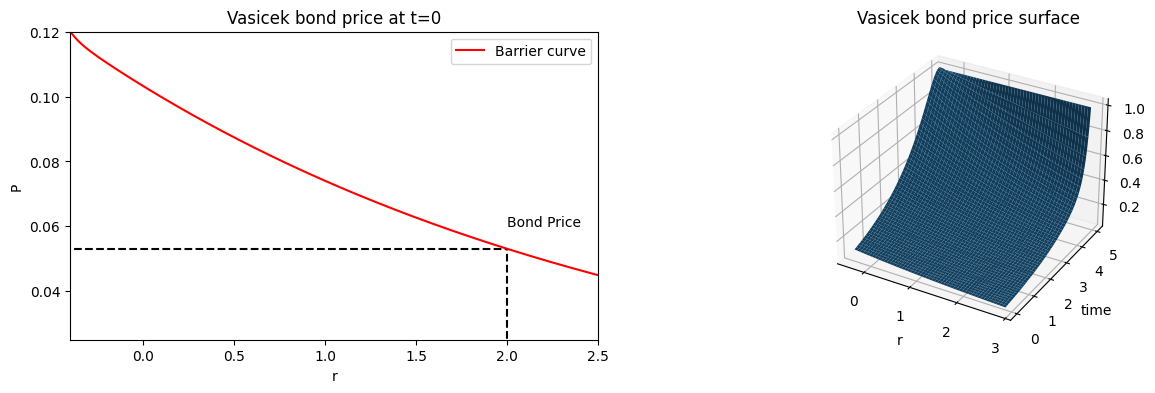

In [19]:
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection="3d")

ax1.text(X0, 0.06, "Bond Price")
ax1.plot([X0, X0], [0, Price], "k--")
ax1.plot([-0.5, X0], [Price, Price], "k--")
ax1.plot(r, V[:, 0], color="red", label="Barrier curve")
ax1.set_xlim(-0.4, 2.5)
ax1.set_ylim(0.025, 0.12)
ax1.set_xlabel("r")
ax1.set_ylabel("P")
ax1.legend(loc="upper right")
ax1.set_title("Vasicek bond price at t=0")

X_plt, Y_plt = np.meshgrid(T_array, r[700:-200])  # I consider [700:-200] to remove lateral boundary effects
ax2.plot_surface(Y_plt, X_plt, V[700:-200])
ax2.set_title("Vasicek bond price surface")
ax2.set_xlabel("r")
ax2.set_ylabel("time")
ax2.set_zlabel("V")
plt.show()

<a id='sec3'></a>
# Tracking the OU process

In this section I consider a **state space model** with a state process $\{X_t, 0\leq t \leq T\}$ following an OU process and an observation (or measurement) process $\{Y_t, 0\leq t \leq T\}$. 

In order to estimate the true state process, I will make use of the **Kalman filter**. I have alread presented the topic in the notebook **5.1** and showed its applications in the notebooks **5.2** and **5.3**.

In order to create an observation process, let's add some noise to the true state process we have simulated at the beginning of the book.      

In [20]:
sig_eta = std_resid
var_eta = sig_eta**2  # error of the true state process
sig_eps = 0.1
var_eps = sig_eps**2  # error of the measurement

In [21]:
np.random.seed(seed=42)
eps = ss.norm.rvs(loc=0, scale=sig_eps, size=N)  # additional gaussian noise
eps[0] = 0
Y_1 = X_1 + eps  # process + noise = measurement process

#### Plot true process vs measurement process

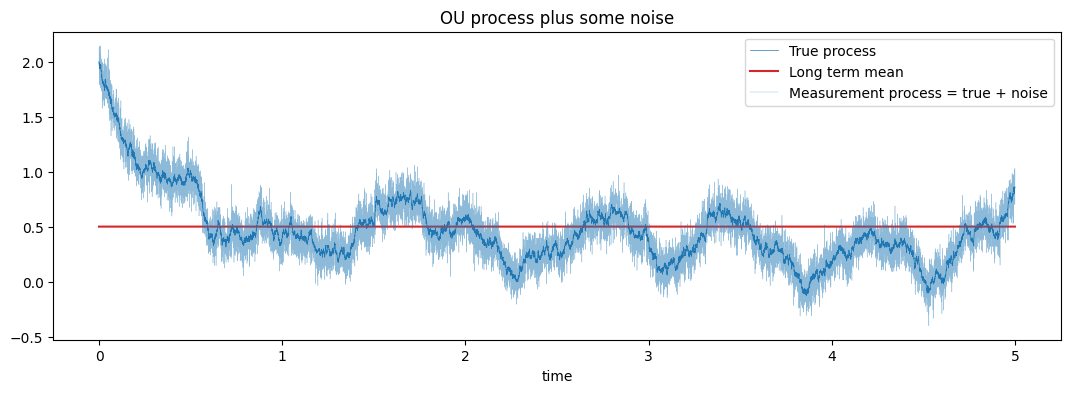

In [22]:
fig = plt.figure(figsize=(13, 4))
plt.plot(T_vec, X_1, linewidth=0.5, alpha=1, label="True process", color="#1f77b4")
plt.plot(T_vec, theta * np.ones_like(T_vec), label="Long term mean", color="#d62728")
plt.plot(T_vec, Y_1, linewidth=0.3, alpha=0.5, label="Measurement process = true + noise", color="#1f77b4")
plt.legend()
plt.title("OU process plus some noise")
plt.xlabel("time")
plt.show()

### Gaussian linear state space model:

**State equation:**

$$ x_k = \alpha + \beta x_{k-1} + \eta_k \quad \text{with} \quad \eta_{k} \sim \mathcal{N}(0,\sigma_{\eta}^2). $$

**Measurment equation:**

$$ y_k= \; x_k + \epsilon_k \quad \text{with} \quad \epsilon_k \sim \mathcal{N}\bigg(0,\sigma_{\epsilon}^2 \bigg).$$

### Kalman filter:

Let us identify the Kalman filter elements. You can find them in the notebook **5.1** or in the [wiki page](https://en.wikipedia.org/wiki/Kalman_filter#Details).
In order to get $F_k$, we need to rewrite the state equation as

$$
\biggl(\begin{array}{c}  1 \\ x_k \end{array} \biggr) = 
\biggl(\begin{array}{cc} 1 & 0\\ \alpha & \beta \end{array}\biggr)
\biggl(\begin{array}{c}  1 \\ x_{k-1} \end{array}\biggr) +
\biggl(\begin{array}{c} 0\\ \eta_k \end{array}\biggr) \quad \text{with}  \quad
\eta_k \sim \mathcal{N}(0, \sigma^2_{\eta}) $$

such that $F_k = \biggl(\begin{array}{cc} 1 & 0\\ \alpha & \beta \end{array}\biggr) $
and then ignore the first line. The matrix $ H_k=1$.    

##### Predict step:
$$ \hat x_{k \mid k-1} = \alpha + \beta \, \hat x_{k-1 \mid k-1} \quad \quad \text{and} \quad \quad  P_{k \mid k-1} = \beta^2 \, P_{k-1 \mid k-1} + \sigma_{\eta}^2. $$

##### Auxiliary variables:
$$ 
\begin{aligned}
\tilde r_k &= y_k - \hat x_{k \mid k-1} &\quad \quad \text{(pre-fit residual)} \\
S_k &= P_{k \mid k-1} + \sigma_{\epsilon}^2 &\quad \quad \text{(conditional innovation covariance)} \\
K_k &= \frac{P_{k \mid k-1}}{S_k} &\quad \quad \text{(Kalman Gain)}
\end{aligned}
$$

##### Update step:
$$ \hat x_{k \mid k} = \hat x_{k \mid k-1} + K_k \, \tilde r_k  \quad \text{and} \quad 
P_{k \mid k} = P_{k \mid k-1} \biggl( 1- K_k \biggr)
$$

##### Log-likelihood:
    
The log-likelihood function is:

$$ \log L \big( \alpha,\beta, \sigma_{\eta}, \sigma_{\epsilon} \mid y_k, y_{k-1}, ..., y_1, y_0 \big) = -\frac{1}{2} 
\sum_{k=1}^N \biggl( \log 2\pi + \log S_k + \frac{\tilde r_k^2}{S_k}  \biggr)
$$

In [23]:
def Kalman(Y, x0, P0, alpha, beta, var_eta, var_eps):
    """Kalman filter algorithm for the OU process."""

    N = len(Y)  # length of measurements
    xs = np.zeros_like(Y)  # Initialization
    Ps = np.zeros_like(Y)

    x = x0
    P = P0  # initial values of h and P
    log_2pi = np.log(2 * np.pi)
    loglikelihood = 0  # initialize log-likelihood

    for k in range(N):
        # Prediction step
        x_p = alpha + beta * x  # predicted h
        P_p = beta**2 * P + var_eta  # predicted P

        # auxiliary variables
        r = Y[k] - x_p  # residual
        S = P_p + var_eps
        KG = P_p / S  # Kalman Gain

        # Update step
        x = x_p + KG * r
        P = P_p * (1 - KG)

        loglikelihood += -0.5 * (log_2pi + np.log(S) + (r**2 / S))
        xs[k] = x
        Ps[k] = P

    return xs, Ps, loglikelihood

#### Train and test split

In [24]:
skip_data = 1000
training_size = 5000
train = Y_1[skip_data : skip_data + training_size]
test = Y_1[skip_data + training_size :]

## Initial guess for teh parameters
guess_beta, guess_alpha, _, _, _ = ss.linregress(train[1:], train[:-1])
guess_var_eps = np.var(train[:-1] - guess_beta * train[1:] - guess_alpha, ddof=2)

### MLE estimation

In [25]:
def minus_likelihood(c):
    """Returns the negative log-likelihood"""
    _, _, loglik = Kalman(train, X0, 10, c[0], c[1], c[2], c[3])
    return -loglik


result = minimize(
    minus_likelihood,
    x0=[guess_alpha, guess_beta, 0.01, guess_var_eps],
    method="L-BFGS-B",
    bounds=[[-1, 1], [1e-15, 1], [1e-15, 1], [1e-15, 1]],
    tol=1e-12,
)
kalman_params = result.x
alpha_KF = kalman_params[0]
beta_KF = kalman_params[1]
var_eta_KF = kalman_params[2]
var_eps_KF = kalman_params[3]
print(result)

      fun: -4220.805792624165
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00027285, -0.0001819 , -0.0005457 ,  0.00172804])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 265
      nit: 34
     njev: 53
   status: 0
  success: True
        x: array([3.80842196e-04, 9.99104066e-01, 5.73528207e-05, 1.00264003e-02])


The estimated parameters are very good! 
Below we can see the error of the estimation:

In [26]:
print(f"Error in estimation of alpha = {(np.abs(alpha-alpha_KF)/alpha *100).round(2)}%")
print(f"Error in estimation of beta = {(np.abs(beta-beta_KF)/beta *100).round(4)}%")
print(f"Error in estimation of var eta = {(np.abs(var_eta-var_eta_KF)/var_eta *100).round(2)}%")
print(f"Error in estimation of var eps = {(np.abs(var_eps-var_eps_KF)/var_eps *100).round(2)}%")

Error in estimation of alpha = 9.85%
Error in estimation of beta = 0.0035%
Error in estimation of var eta = 7.81%
Error in estimation of var eps = 0.26%


#### Kalman smoother

Let's implement the [RTS](https://en.wikipedia.org/wiki/Kalman_filter#Rauch%E2%80%93Tung%E2%80%93Striebel) smoother.

In addition to the smooth state and variance process, here I also estimate the smooth covariance $P_{k-1,k \mid N}$ (called `Cs_smooth` in the code).

$$ \hat x_{k\mid N} = \mathbb{E}\biggl[x_k \bigg| y_N,...,y_0\biggr] \quad \text{and} \quad 
P_{k-1,k \mid N} = \mathbb{E}\biggl[ \bigl(x_k-\hat x_{k\mid N}\bigr) \bigl(x_{k-1}-\hat x_{k-1\mid N}\bigr) \,\bigg |  \, y_N,...,y_0\biggr] $$

The formulas to obtain $P_{k-1,k \mid N}$ are long and can be found in [3] or in the Appendix of [7].     
Here I just write the python code:

In [27]:
def Smoother(Y, x0, P0, alpha, beta, var_eta, var_eps):
    """Kalman smoother"""

    xs, Ps, _ = Kalman(Y, x0, P0, alpha, beta, var_eta, var_eps)

    xs_smooth = np.zeros_like(xs)
    Ps_smooth = np.zeros_like(Ps)
    Cs_smooth = np.zeros_like(Ps)
    C = np.zeros_like(Ps)
    xs_smooth[-1] = xs[-1]
    Ps_smooth[-1] = Ps[-1]
    K = (beta**2 * Ps[-2] + var_eta) / (beta**2 * Ps[-2] + var_eta + var_eps)
    Cs_smooth[-1] = Ps[-1]
    Cs_smooth[-2] = beta * (1 - K) * Ps[-2]

    for k in range(len(xs) - 2, -1, -1):
        C[k] = beta * Ps[k] / (beta**2 * Ps[k] + var_eta)
        xs_smooth[k] = xs[k] + C[k] * (xs_smooth[k + 1] - (alpha + xs[k] * beta))
        Ps_smooth[k] = Ps[k] + C[k] ** 2 * (Ps_smooth[k + 1] - (beta**2 * Ps[k] + var_eta))
        if k == (len(xs) - 2):
            continue
        Cs_smooth[k] = C[k] * Ps[k + 1] + C[k] * C[k + 1] * (
            Cs_smooth[k + 1] - beta * Ps[k + 1]
        )  # covariance x(k) and x(k+1)
    return xs_smooth, Ps_smooth, Cs_smooth

In [28]:
x_tmp, P_tmp, _ = Kalman(train, 1, 10, alpha_KF, beta_KF, var_eta_KF, var_eps_KF)  # to get initial values for KF
xs, Ps, _ = Kalman(test, x_tmp[-1], P_tmp[-1], alpha_KF, beta_KF, var_eta_KF, var_eps_KF)
x_smooth, P_smooth, _ = Smoother(test, x_tmp[-1], P_tmp[-1], alpha_KF, beta_KF, var_eta_KF, var_eps_KF)
V_up = xs + np.sqrt(Ps)  # error up bound
V_down = xs - np.sqrt(Ps)  # error down bound

#### Plot

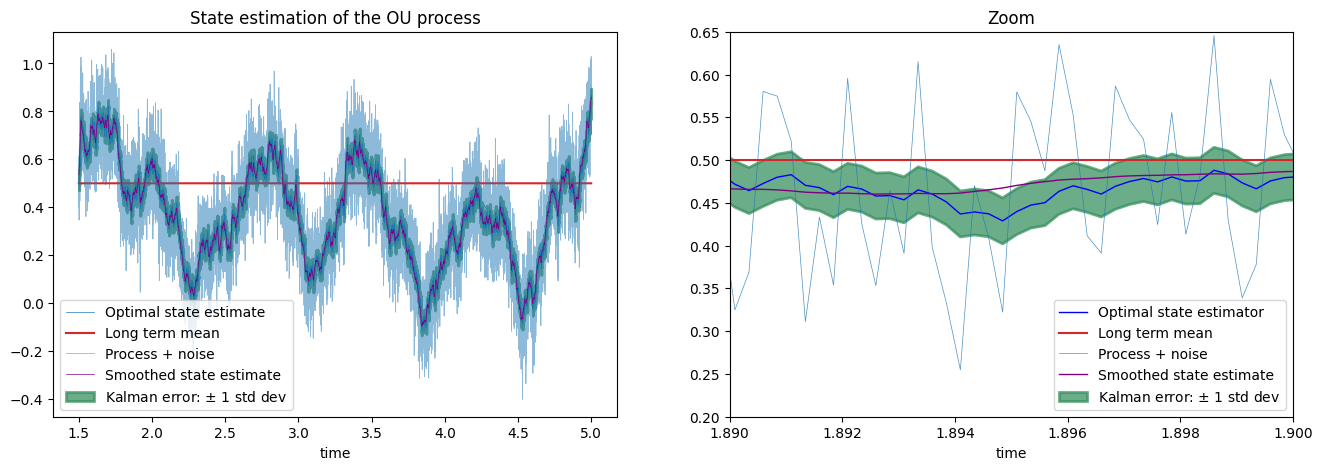

In [29]:
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(
    T_vec[skip_data + training_size :], xs, linewidth=0.5, alpha=1, label="Optimal state estimate", color="#1f77b4"
)
ax1.plot(T_vec[skip_data + training_size :], theta * np.ones_like(xs), label="Long term mean", color="#d62728")
ax1.plot(
    T_vec[skip_data + training_size :],
    Y_1[skip_data + training_size :],
    linewidth=0.6,
    alpha=0.5,
    label="Process + noise",
    color="#1f77b4",
)
ax1.plot(
    T_vec[skip_data + training_size :],
    x_smooth,
    linewidth=0.5,
    alpha=1,
    label="Smoothed state estimate",
    color="purple",
)
ax1.fill_between(
    x=T_vec[skip_data + training_size :],
    y1=V_up,
    y2=V_down,
    alpha=0.7,
    linewidth=2,
    color="seagreen",
    label="Kalman error: $\pm$ 1 std dev ",
)
ax1.legend()
ax1.set_title("State estimation of the OU process")
ax1.set_xlabel("time")
ax2.plot(T_vec[skip_data + training_size :], xs, linewidth=1, alpha=1, label="Optimal state estimator", color="blue")
ax2.plot(T_vec[skip_data + training_size :], theta * np.ones_like(xs), label="Long term mean", color="#d62728")
ax2.plot(
    T_vec[skip_data + training_size :],
    Y_1[skip_data + training_size :],
    linewidth=0.5,
    alpha=0.8,
    label="Process + noise",
    color="#1f77b4",
)
ax2.plot(
    T_vec[skip_data + training_size :], x_smooth, linewidth=1, alpha=1, label="Smoothed state estimate", color="purple"
)
ax2.fill_between(
    x=T_vec[skip_data + training_size :],
    y1=V_up,
    y2=V_down,
    alpha=0.7,
    linewidth=2,
    color="seagreen",
    label="Kalman error: $\pm$ 1 std dev ",
)
ax2.set_xlim(1.89, 1.9)
ax2.set_ylim(0.2, 0.65)
ax2.legend()
ax2.set_title("Zoom")
ax2.set_xlabel("time")
plt.show()

Let's have a look at the errors:

In [30]:
print("Test set, mean linear error Kalman: ", np.linalg.norm(xs - X_1[skip_data + training_size :], 1) / len(xs))
print("Average standard deviation of the estimate: ", np.mean(np.sqrt(Ps)))
print("Test set, MSE Kalman: ", np.linalg.norm(xs - X_1[skip_data + training_size :], 2) ** 2 / len(xs))
print("Test set, MSE Smoother: ", np.linalg.norm(x_smooth - X_1[skip_data + training_size :], 2) ** 2 / len(x_smooth))

Test set, mean linear error Kalman:  0.02139263694145294
Average standard deviation of the estimate:  0.0268739537722376
Test set, MSE Kalman:  0.0007199864260969918
Test set, MSE Smoother:  0.00040624843989773933


Looking at the mean linear error value, we can see that the average distance of the estimated process from the true hidden process is smaller that the average standard deviation. 

<a id='sec3.1'></a>
## Iterative approach for parameters estimation

This method is described by Shumway and Stoffer (1982) in [7] and is an off-line calculation that
makes use of smoother estimators for the Kalman Filter.      
The Shumway and Stoffer algorithm has been widely tested (for instance in [3]).

Let's recall the formulas for this iterative algorithm (taken from [3]).     
Let's start with an initial guess 
$(\alpha, \beta, \sigma_{\eta}^2, \sigma_{\epsilon}^2)$ and then compute the new parameters:

$$ \alpha = \frac{(AC-BD)}{NA - D^2}, \quad  \beta = \frac{NB-CD}{NA - D^2}, \quad \sigma_{\epsilon}^2 = \frac{1}{N+1} \sum_{k=0}^N y_k^2 - 2 y_k \hat x_{k\mid N} + P_{k\mid N} + \hat x_{k\mid N}^2, $$
$$\sigma_{\eta}^2 = \frac{1}{N} \sum_{k=1}^{N} \biggl[ P_{k \mid N} + \hat x_{k\mid N}^2 + \alpha^2 + \beta^2 P_{k-1 \mid N} + \beta^2 \hat x_{k-1\mid N}^2 - 2 \alpha \hat x_{k\mid N} + 2 \alpha \beta \hat x_{k-1\mid N} 
-2 \beta P_{k-1,k \mid N} -2 \beta \hat x_{k\mid N} \hat x_{k-1\mid N} \biggr].$$

Very long formulas... where I introduced:

$$ A = \sum_{k=1}^{N} \bigl[ P_{k-1 \mid N} + \hat x_{k-1\mid N}^2 \bigr], \quad 
B = \sum_{k=1}^{N} \bigl[ P_{k-1, k \mid N} + \hat x_{k-1\mid N} \hat x_{k\mid N} \bigr], \quad 
C = \sum_{k=1}^{N} \hat x_{k\mid N}, \quad
D = \sum_{k=1}^{N} \hat x_{k-1 \mid N} $$

The iteration runs until the improvements (measured by relative errors) are smaller than a specified error.

In [31]:
N_max = 1000  # number of iterations
err = 0.001  # error in the parameters
NN = len(train)
alpha_SS = guess_alpha  # initial guess
beta_SS = guess_beta  # initial guess
var_eps_SS = guess_var_eps  # initial guess
var_eta_SS = 0.1  # initial guess
x_start = 1  # initial guess
P_start = 10  # initial guess

In [32]:
for i in range(N_max):
    a_old = alpha_SS
    b_old = beta_SS
    eta_old = var_eta_SS
    eps_old = var_eps_SS

    x_sm, P_sm, C_sm = Smoother(train, x_start, P_start, alpha_SS, beta_SS, var_eta_SS, var_eps_SS)

    AA = np.sum(P_sm[:-1] + x_sm[:-1] ** 2)  # A
    BB = np.sum(C_sm[:-1] + x_sm[:-1] * x_sm[1:])  # B
    CC = np.sum(x_sm[1:])  # C
    DD = np.sum(x_sm[:-1])  # D

    alpha_SS = (AA * CC - BB * DD) / (NN * AA - DD**2)
    beta_SS = (NN * BB - CC * DD) / (NN * AA - DD**2)
    var_eta_SS = (
        np.sum(
            P_sm[1:]
            + x_sm[1:] ** 2
            + alpha_SS**2
            + P_sm[:-1] * beta_SS**2
            + (x_sm[:-1] * beta_SS) ** 2
            - 2 * alpha_SS * x_sm[1:]
            + 2 * alpha_SS * beta_SS * x_sm[:-1]
            - 2 * beta_SS * C_sm[:-1]
            - 2 * beta_SS * x_sm[1:] * x_sm[:-1]
        )
        / NN
    )
    var_eps_SS = np.sum(train**2 - 2 * train * x_sm + P_sm + x_sm**2) / (NN + 1)

    if (
        (np.abs(a_old - alpha_SS) / a_old < err)
        and (np.abs(b_old - beta_SS) / b_old < err)  # iterate until there is no improvement
        and (np.abs(eta_old - var_eta_SS) / eta_old < err)
        and (np.abs(eps_old - var_eps_SS) / eps_old < err)
    ):
        print("Number of iteration: ", i)
        break
if i == N_max - 1:
    print("Maximum number of iterations reached ", i + 1)

Number of iteration:  209


##### Comparison of the estimated values with the values obtained from the true state process:

In [33]:
print(f"Value of estimated alpha = {alpha_SS} vs real alpha = {alpha}")
print(f"Value of estimated beta = {beta_SS} vs real beta = {beta}")
print(f"Value of estimated var_eta = {var_eta_SS} vs real var_eta = {var_eta}")
print(f"Value of estimated var_eps = {var_eps_SS} vs real var_eps = {var_eps}")

Value of estimated alpha = 0.0003889527495165138 vs real alpha = 0.00034670318459772975
Value of estimated beta = 0.9990889510785665 vs real beta = 0.9991391221590096
Value of estimated var_eta = 5.941249134231912e-05 vs real var_eta = 6.221125725286099e-05
Value of estimated var_eps = 0.010018385724213947 vs real var_eps = 0.010000000000000002


##### We can see that this algorithm works very well.  
It is a good alternative to the numerical maximization of the loglikelihood function used in the previous section.

<a id='sec4'></a>
## Trading strategy 

Let us assume that our OU process describes the dynamics of an asset, or a portfolio of assets.      
We can implement a trading strategy that takes advantage from the mean reversion. This strategy is better known as [pair trading](https://en.wikipedia.org/wiki/Pairs_trade) (or, more in general, statistical arbitrage).

The mechanics of the strategy (taken from [8]) is the following:    
- set two bands above and below the asymptotic mean (usually at one asymptotic standard deviation) for opening the position.
    - buy if the lower band is crossed
    - sell if the upper band is crossed
- set two (smaller) bands to close the position (usually at 1/10 of the standard deviation).

Now let us simulate again the process:

In [34]:
N = 1000  # time steps
paths = 5000  # simulated paths
X0 = 0  # initial position
kappa = 10
theta = 0
sigma = 2
T = 1  # terminal time
std_asy = np.sqrt(sigma**2 / (2 * kappa))  # open position
std_10 = std_asy / 10  # close position

In [35]:
np.random.seed(seed=41)
OU = OU_process(sigma=sigma, theta=theta, kappa=kappa)  # creates the OU object
X = OU.path(X0=X0, T=T, N=N, paths=paths)  # path simulation
process = 0  # the process for the plot
T_vec, dt = np.linspace(0, T, N, retstep=True)

In [36]:
def strategy(X, mean=0, std_open=0.5, std_close=0.05, TC=0):
    """Implementation of the strategy.
        - std_open = levels for opening the position.
        - std_close = levels for closing the position.
        - TC = Transaction costs
    Returns:
        - status:  at each time says if we are long=1, short=-1 or we have no open positions = 0
        - cash: the cumulative amount of cash gained by the strategy.
        At terminal time if there is an open position, it is closed.
    """
    status = np.zeros_like(X)
    cash = np.zeros_like(X)
    cash[0] = X0
    for i, x in enumerate(X):
        if i == 0:
            continue
        if (status[i - 1] == 1) and (x >= mean - std_close):
            status[i] = 0
            cash[i] += x * (1 + TC)
        elif (status[i - 1] == -1) and (x <= mean + std_close):
            status[i] = 0
            cash[i] -= x * (1 + TC)
        elif (status[i - 1] == 0) and (x >= mean + std_open):
            status[i] = -1
            cash[i] += x * (1 + TC)
        elif (status[i - 1] == 0) and (x <= mean - std_open):
            status[i] = 1
            cash[i] -= x * (1 + TC)
        else:
            status[i] = status[i - 1]

    if status[-1] == 1:
        cash[-1] += x * (1 + TC)
    if status[-1] == -1:
        cash[-1] -= x * (1 + TC)

    return status, cash.cumsum()

In [37]:
status, cash = strategy(X[process], mean=theta, std_open=std_asy, std_close=std_10, TC=0)

In [38]:
PnL = []  # Profit and loss for this strategy
for i in range(paths):
    PnL.append(strategy(X[i], mean=theta, std_open=std_asy, std_close=std_10, TC=0)[1][-1])
PnL = np.array(PnL)

#### Plot:

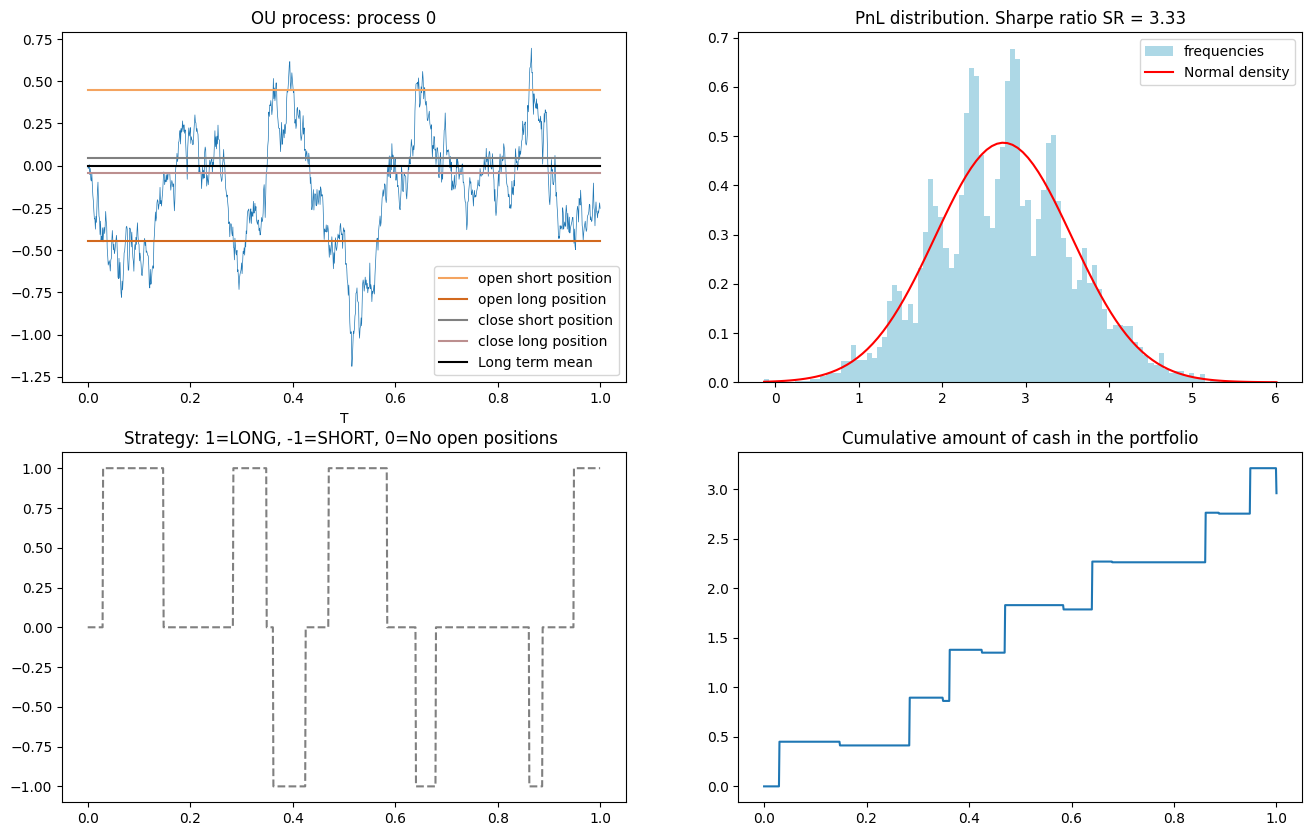

In [39]:
fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(222)
ax4 = fig.add_subplot(224)
ax1.plot(T_vec, X[process, :].T, linewidth=0.5)
ax1.plot(T_vec, (theta + std_asy) * np.ones_like(T_vec), label="open short position", color="sandybrown")
ax1.plot(T_vec, (theta - std_asy) * np.ones_like(T_vec), label="open long position", color="chocolate")
ax1.plot(T_vec, (theta + std_10) * np.ones_like(T_vec), label="close short position", color="gray")
ax1.plot(T_vec, (theta - std_10) * np.ones_like(T_vec), label="close long position", color="rosybrown")
ax1.plot(T_vec, theta * np.ones_like(T_vec), label="Long term mean", color="black")
ax1.legend()
ax1.set_title(f"OU process: process {process}")
ax1.set_xlabel("T")

ax2.plot(T_vec, status, linestyle="dashed", color="grey")
ax2.set_title("Strategy: 1=LONG, -1=SHORT, 0=No open positions ")

ax3.hist(PnL, density=True, bins=100, facecolor="LightBlue", label="frequencies")
x = np.linspace(PnL.min(), PnL.max(), 100)
ax3.plot(x, ss.norm.pdf(x, loc=PnL.mean(), scale=PnL.std()), color="r", label="Normal density")
SR = PnL.mean() / PnL.std()
ax3.legend()
ax3.set_title(f"PnL distribution. Sharpe ratio SR = {SR.round(2)}")

ax4.plot(T_vec, cash)
ax4.set_title("Cumulative amount of cash in the portfolio")
plt.show()

The histogram is computed considering the $PnL$ of each generated path.    
The obtained distribution is a multimodal distribution where each peak is roughly a multiple of the band size.

From the *Cumulative amount of cash* plot, we can see that we make money when we open the position. When the position is closed, a small amount of money is lost.     
At terminal time the position must be closed.  

The **sharpe ratio** is defined as $SR = \frac{\mathbb{E}[PnL]}{\text{Std}[PnL]}$. There are alternative definitions involving net returns and log-returns, however here it makes more sense to consider the $PnL$ (when the initial value is 0, returns are not defined).

<a id='sec5'></a>
## First time to exit the strip

Let us assume the process at time $t=0$ is contained in the strip formed by the two asymptotic standard deviations i.e. 

$$\theta - \sqrt{\frac{\sigma^2}{2\kappa}} \leq \, X_0 \leq \, \theta + \sqrt{\frac{\sigma^2}{2\kappa}}.$$ 

What is the expected time to exit this strip? 

We can estimate the time using the **Monte Carlo** simulated data, by simply taking the average of the first times the process touches the above or below lines.      (since argmax return zero if it can find a True value, check if there are zeros and if there are, replace them with a high value)

In [40]:
T_to_asy = np.argmax(np.logical_or(X <= -std_asy, X >= std_asy), axis=1) * dt  # first exit time
print("Are there paths that never exit the strip?", (T_to_asy == 0).any())  # argmax returns 0 if it can't find

Are there paths that never exit the strip? False


In [41]:
print(f"The expected time is {T_to_asy.mean()} with standard error {ss.sem(T_to_asy)}")

The expected time is 0.07237557557557558 with standard error 0.0008702354136411929


### ODE approach

The expected time $U$ is the solution of the following differential equation:

$$ \kappa (\theta - x) \frac{dU}{dx} + \frac{1}{2} \sigma^2 \frac{d^2 U}{dx^2} = -1$$

with boundary conditions:

$$ U(B_1) = U(B_2) = 0. $$

Here I called $B_1,B_2$ the levels of the asymptiotic standard deviation. 
This formula comes from [9], Chapter 10.9.

#### Discretization

This is a boudary value problem, that can be solved by a finite difference method. The discretization scheme is very similatr to the scheme I used for the Vasicek PDE:

$$
          + \max \biggl( \kappa(\theta-x_i),\, 0 \biggr) \frac{U_{i+1} - U_{i}}{ \Delta x} 
          + \min \biggl( \kappa(\theta-x_i),\, 0 \biggr) \frac{U_{i} - U_{i-1}}{ \Delta x} 
          + \frac{1}{2} \sigma^2  \frac{U_{i+1} + U_{i-1} - 2 U_{i}}{\Delta x^2} 
          + 1  = 0. 
$$

Again, let's call $\text{max}_i = \max \bigl( \kappa(\theta-x_i),\, 0 \bigr)$ and $\text{min}_i = \min \bigl( \kappa(\theta-x_i),\, 0 \bigr)$.     
We can rewrite the equation above as:

$$ 
-1 = \; U_{i-1} \underbrace{\biggl( - \frac{\text{min}_i}{\Delta x} + \frac{1}{2} 
\frac{\sigma^2}{\Delta x^2} \biggr)}_{a}  
              + U_{i} \underbrace{\biggl( \frac{( \text{min}_i - \text{max}_i )}{\Delta x} + \frac{\sigma^2}{\Delta x^2} \biggr) }_{b}
              + U_{i+1} \underbrace{\biggl( \frac{\text{max}_i}{\Delta x} + \frac{1}{2} 
\frac{\sigma^2}{\Delta x^2} \biggr)}_{c}
$$

That in matrix form becomes 

$$ \mathcal{D}\, U = -1 $$

where $\mathcal{D}$ is the usual tridiagonal matrix.  

In [42]:
Nspace = 100000  # space steps
x_max = theta + std_asy
x_min = theta - std_asy
x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)  # space discretization

U = np.zeros(Nspace)  # grid initialization
constant_term = -np.ones(Nspace - 2)  # -1

# construction of the tri-diagonal matrix D
sig2 = sigma * sigma
dxx = dx * dx
max_part = np.maximum(kappa * (theta - x), 0)  # upwind positive part
min_part = np.minimum(kappa * (theta - x), 0)  # upwind negative part

a = -min_part / dx + 0.5 * sig2 / dxx
b = (min_part - max_part) / dx - sig2 / dxx
c = max_part / dx + 0.5 * sig2 / dxx

aa = a[1:]
cc = c[:-1]  # upper and lower diagonals
D = sparse.diags([aa, b, cc], [-1, 0, 1], shape=(Nspace - 2, Nspace - 2)).tocsc()  # matrix D
U[1:-1] = spsolve(D, constant_term)

#### Plot expected time

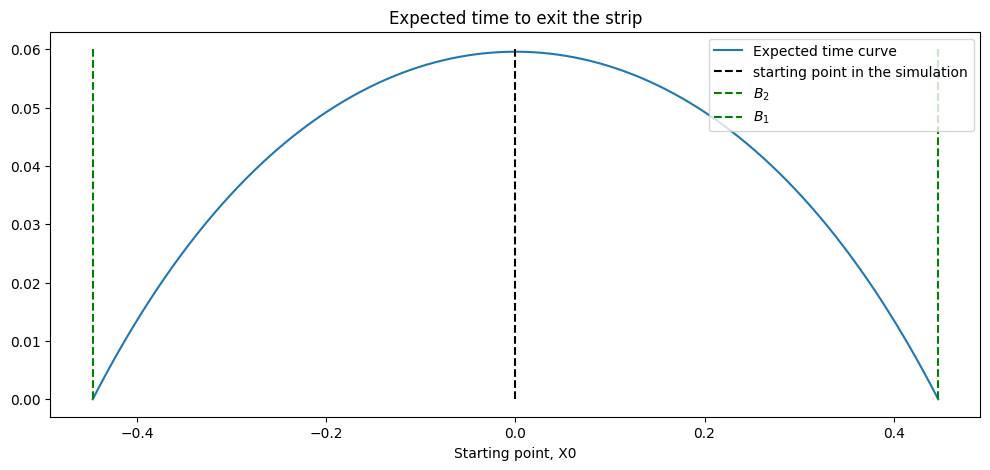

In [43]:
fig = plt.figure(figsize=(12, 5))
plt.plot(x, U, label="Expected time curve")
plt.plot([X0, X0], [0, 0.06], "k--", label="starting point in the simulation")
plt.plot([x_max, x_max], [0, 0.06], "g--", label="$B_2$")
plt.plot([x_min, x_min], [0, 0.06], "g--", label="$B_1$")
plt.legend(loc="upper right")
plt.xlabel("Starting point, X0")
plt.title("Expected time to exit the strip")
plt.show()

In [44]:
expected_t_ode = np.interp(X0, x, U)
print(f"The expected time starting at X_0={X0},computed by ODE is {expected_t_ode}")

The expected time starting at X_0=0,computed by ODE is 0.05957467041328912


### Distribution of the first exit time from the strip

If we call $\tau$ the first exit time, let us indicate with $P(t',x; T) = \mathbb{P}\big(\tau<T \,|\, X_{t'}=x \big) = \mathbb{E}\big[\mathbb{1}_{\tau<T} \,|\, X_{t'}=x \big]$ the cumulative distribution function of $\tau$ representing the probability of $\{X_u\, : \, t'\leq u \leq T\}$ to exit the strip before $T$.     
Since we are interested in the forward evolution, let us define (with abuse of notation) $t = T-t'$.     
The distribution $P(t,x)$ is solution of the following (forward) PDE (see [9] Chapter 10.8):

$$ \frac{\partial  P(t,x)}{\partial t}  =
            \kappa (\theta - x) \frac{\partial P(t,x)}{\partial x}
          + \frac{1}{2} \sigma^2 \frac{\partial^2  P(t,x)}{\partial x^2}. $$
     
with boundary conditions:

$$ P(0,x) = 0, \quad \quad P(t, B_1) = P(t, B_2) = 1 \quad \text{for each }\quad 0 \leq t\leq T $$
            
where again $B_1, B_2$ are the upper and lower barriers.

The equation is almost identical to the PDE for bond pricing we found in [Sectiton Bond](#sec2), therefore the discretization is the same. The only difference is the time that goes forward.

In [45]:
Nspace = 6000  # M space steps
Ntime = 8000  # N time steps
x_max = theta + std_asy  # B2
x_min = theta - std_asy  # B1
x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)  # space discretization
T_array, Dt = np.linspace(0, T, Ntime, retstep=True)  # time discretization
Payoff = 0  # payoff

V = np.zeros((Nspace, Ntime))  # grid initialization
offset = np.zeros(Nspace - 2)  # vector to be used for the boundary terms
V[:, 0] = Payoff  # initial condition
V[-1, :] = 1  # lateral boundary condition
V[0, :] = 1  # lateral boundary condition

# construction of the tri-diagonal matrix D
sig2 = sigma * sigma
dxx = dx * dx
max_part = np.maximum(kappa * (theta - x[1:-1]), 0)  # upwind positive part
min_part = np.minimum(kappa * (theta - x[1:-1]), 0)  # upwind negative part

a = min_part * (Dt / dx) - 0.5 * (Dt / dxx) * sig2
b = 1 + (Dt / dxx) * sig2 + Dt / dx * (max_part - min_part)
c = -max_part * (Dt / dx) - 0.5 * (Dt / dxx) * sig2

a0 = a[0]
cM = c[-1]  # boundary terms
aa = a[1:]
cc = c[:-1]  # upper and lower diagonals
D = sparse.diags([aa, b, cc], [-1, 0, 1], shape=(Nspace - 2, Nspace - 2)).tocsc()  # matrix D

for n in range(Ntime - 1):
    # forward computation
    offset[0] = a0 * V[0, n]
    offset[-1] = cM * V[-1, n]
    V[1:-1, n + 1] = spsolve(D, (V[1:-1, n] - offset))

In [46]:
fn = RegularGridInterpolator((x, T_array), V, bounds_error=False, fill_value=None)  # interpolator at X0
Cumulative = fn((X0, T_array))  # Cumulative at x=X0
distribution = (Cumulative[1:] - Cumulative[:-1]) / Dt  # Density

#### Plot

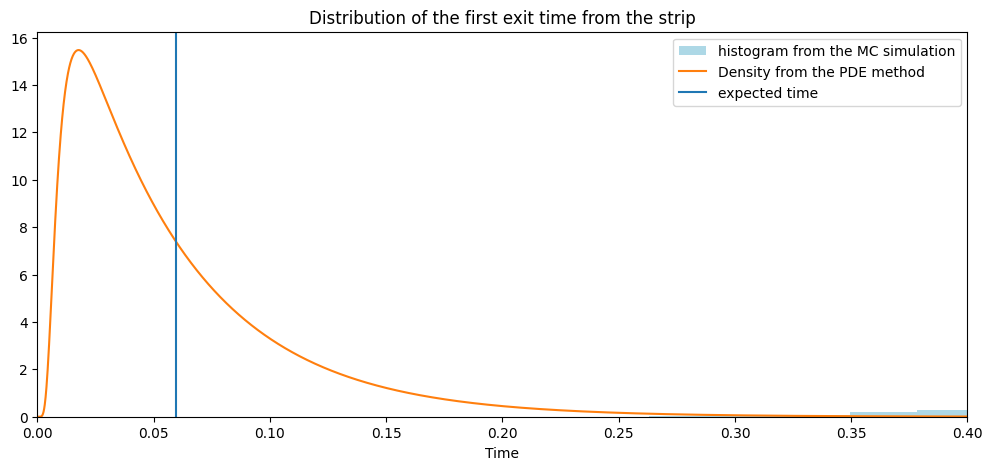

In [47]:
fig = plt.figure(figsize=(12, 5))
plt.xlabel("Time")
plt.title("Distribution of the first exit time from the strip")
plt.hist(T_to_theta, density=True, bins=100, facecolor="LightBlue", label="histogram from the MC simulation")
plt.plot(T_array[:-1], distribution, label="Density from the PDE method")
plt.axvline(expected_t_ode, label="expected time")
plt.xlim([0, 0.4])
plt.legend()
plt.show()

In [48]:
exp_t_integral = distribution @ T_array[:-1] * Dt  # integral of t*density(t)*dt
print(f"Expected value from density tau={exp_t_integral} corresponds to PDE tau={expected_t_ode}")

Expected value from density tau=0.05957056936631631 corresponds to PDE tau=0.05957467041328912


## References

[1] Thijs van den Berg, [Calibrating the Ornstein-Uhlenbeck(Vasicek) model](https://www.statisticshowto.com/wp-content/uploads/2016/01/Calibrating-the-Ornstein.pdf)

[2] Brigo and Mercurio, *Interest Rate Models - Theory and Practice: With Smile, Inflation and Credit*

[3] Robert J. Elliott , John Van Der Hoek & William P. Malcolm, *Pairs trading*, Quantitative Finance, (2007)

[4] Finch, S., [Ornstein–Uhlenbeck process](https://oeis.org/A249417/a249417.pdf), (2004).

[5] Alexander Lipton, Vadim Kaushansky, [On the First Hitting Time Density of an
Ornstein-Uhlenbeck Process](https://arxiv.org/pdf/1810.02390.pdf), (2018)

[6] L. M. Ricciardi and S. Sato, First-passage-time density and moments of the Ornstein-Uhlenbeck process, J. Appl. Probab. 25 (1988)

[7] Shumway, R.H. and Stoffer, D.S., *An approach to time series smoothing and forecasting using the EM algorithm*, Journal of Time Series, (1982)

[8] Cartea, A., Jaimungal, S., and Peñalva, J., *Algorithmic and high frequency trading*. Cambridge University Press, (2015)

[9] Paul Wilmott, *Paul Wilmott on quantitative finance*, (2006)